# Testing the two-level asymptotic form of `Whirl2d`

In [308]:
include(joinpath(Pkg.dir("whirl2d"), "src/Whirl2d.jl"))
import Whirl2d
import Whirl2d:@get
using PyPlot
@get Whirl2d (Systems, Grids, DualPatch, Bodies, TimeMarching, NavierStokes);

### Create a body undergoing a weak oscillatory translation in `x` direction 

In [309]:
Npts = 100
rad = 0.5
xcent = [0.0,0.0]
ang = 0.0
b1 = Bodies.Circle(Npts,rad,xcent,ang)

#xcent = [2.0,0.0]
#b2 = Bodies.Circle(Npts,rad,xcent,ang)

Body: number of points = 100, reference point = (0.0,0.0), rotation matrix = [1.0 -0.0; 0.0 1.0]


### Set the streaming motion

In [310]:
nbody = 1
sparams = Array{NavierStokes.StreamingParams}(nbody)
sparams[1] = NavierStokes.StreamingParams(1.0,1.0,0.0,0.0,0.0)
NavierStokes.set_oscil_motion!(b1,sparams[1])

#sparams[2] = NavierStokes.StreamingParams(1.0,0.0,0.0,0.0,0.0)
#NavierStokes.set_oscil_motion!(b2,sparams[2])

(::X) (generic function with 1 method)

### Create a domain with this body in it

In [311]:
xmin = [-2.0,-2.0]
xmax = [2.0,2.0]
dom = Systems.DualDomain(xmin,xmax)
dom = Systems.add_body(dom,b1)
#dom = Systems.add_body(dom,b2)

Domain: xmin = [-2.0, -2.0], xmax = [2.0, 2.0]
number of bodies = 1
Body: number of points = 100, reference point = (0.0,0.0), rotation matrix = [1.0 -0.0; 0.0 1.0]



#### Add a filling dual grid to this domain
The boundaries of the domain coincide with the boundaries of the dual grid

In [312]:
Δx = 0.02
dom = Systems.add_grid(dom,Δx)

Domain: xmin = [-2.0, -2.0], xmax = [2.0, 2.0]
number of bodies = 1
Body: number of points = 100, reference point = (0.0,0.0), rotation matrix = [1.0 -0.0; 0.0 1.0]

Grid: number of cells = (200,200), Δx = 0.02, xmin = [-2.0, -2.0], xmax = [2.0, 2.0]



### Set the physical and time parameters

In [333]:
Re = 320
physparams = NavierStokes.set_freestream([0.0,0.0])
NavierStokes.set_Re!(physparams,Re)
Δt = min(0.5*Δx,Δx^2*Re)

α = Δt/(Re*Δx^2)
tparams = TimeMarching.TimeParams(Δt,TimeMarching.RK31())

params = (physparams,α,sparams)

(Whirl2d.NavierStokes.PhysParams([0.0, 0.0], 320.0), 0.078125, Whirl2d.NavierStokes.StreamingParams[Whirl2d.NavierStokes.StreamingParams(1.0, 1.0, 0.0, 0.0, 0.0, Whirl2d.NavierStokes.X)])

### Compute the grid and body operators
This fills in the LGF and integrating factor tables, computes the interpolation/regularization operators, computes the Schur complement operators and factorizes them, and defines the operators needed for calling the HERK

In [334]:
@time ops = NavierStokes.set_operators_two_level_body!(dom,params);
A⁻¹,L⁻¹,B₁ᵀ,B₂!,S⁻¹,S₀⁻¹,r₁,r₂ = ops

 15.788940 seconds (148.37 M allocations: 10.353 GiB, 11.91% gc time)


(Whirl2d.NavierStokes.A⁻¹, Whirl2d.NavierStokes.L⁻¹, Whirl2d.NavierStokes.B₁ᵀ, Whirl2d.NavierStokes.B₂!, Whirl2d.NavierStokes.S⁻¹, Whirl2d.NavierStokes.S₀⁻¹, Whirl2d.NavierStokes.r₁, Whirl2d.NavierStokes.r₂)

### Create an initial solution structure

In [335]:
s = NavierStokes.TwoLevelBodySoln(dom)

Solution: t = 0.0


### Advance the solution

In [365]:
@time for i = 1:100
    s = TimeMarching.ifherk!(s,tparams,A⁻¹,B₁ᵀ,B₂!,S⁻¹,S₀⁻¹,r₁,r₂)
end
s.ψ = -L⁻¹(s.u);
s

 64.238713 seconds (637.80 M allocations: 43.831 GiB, 23.03% gc time)


Solution: t = 3.9999999999999587


### Plot the solution

#### Level 1 solution

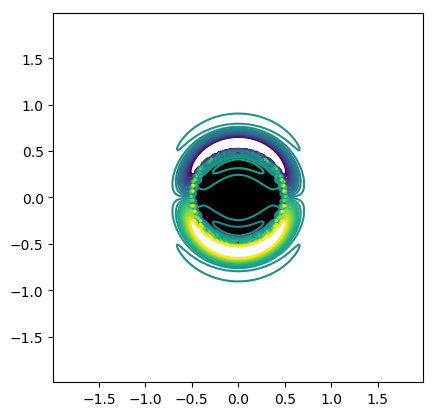

(-1.99, 1.9900000000000002, -1.99, 1.9900000000000002)

In [366]:
x = Grids.xcell(dom.grid)
y = Grids.ycell(dom.grid)
contour(x,y,s.u[1][dom.grid.cellint[1],dom.grid.cellint[2]]/Δx,linspace(-5,5,30))
for j = 1:dom.nbody
    xpt = [dom.body[j].x[i][1] for i = 1:dom.body[j].N]
    ypt = [dom.body[j].x[i][2] for i = 1:dom.body[j].N]
    fill(xpt,ypt,color="k")
end
axis("scaled")

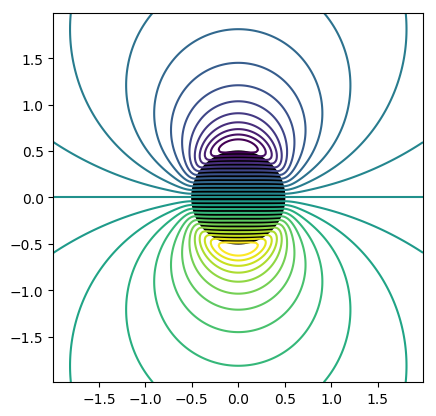

(-1.99, 1.9900000000000002, -1.99, 1.9900000000000002)

In [360]:
contour(x,y,s.ψ[1][dom.grid.cellint[1],dom.grid.cellint[2]]*Δx,31)
for j = 1:dom.nbody
    xpt = [dom.body[j].x[i][1] for i = 1:dom.body[j].N]
    ypt = [dom.body[j].x[i][2] for i = 1:dom.body[j].N]
    fill(xpt,ypt,color="k")
end
axis("scaled")

#### Level 2 solution

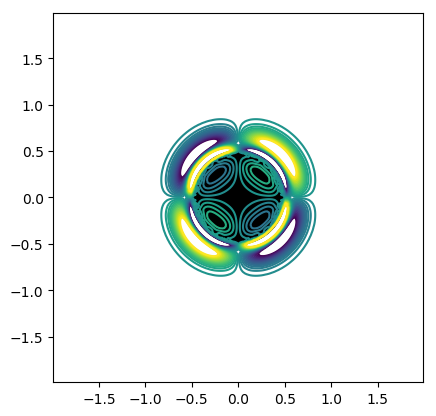

(-1.99, 1.9900000000000002, -1.99, 1.9900000000000002)

In [367]:
x = [dom.grid.xmin[1]+Δx*(i-1/2) for i=1:dom.grid.N[1], j=1:dom.grid.N[2]]
y = [dom.grid.xmin[2]+Δx*(j-1/2) for i=1:dom.grid.N[1], j=1:dom.grid.N[2]]

contour(x,y,s.u[2][dom.grid.cellint[1],dom.grid.cellint[2]]/Δx,linspace(-20,20,30))
for j = 1:dom.nbody
    xpt = [dom.body[j].x[i][1] for i = 1:dom.body[j].N]
    ypt = [dom.body[j].x[i][2] for i = 1:dom.body[j].N]
    fill(xpt,ypt,color="k")
end
axis("scaled")

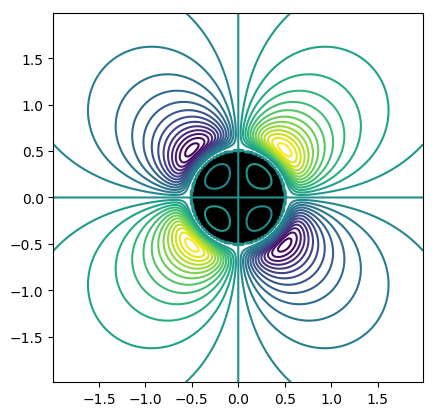

(-1.99, 1.9900000000000002, -1.99, 1.9900000000000002)

In [368]:
contour(x,y,s.ψ[2][dom.grid.cellint[1],dom.grid.cellint[2]]*Δx,31)
for j = 1:dom.nbody
    xpt = [dom.body[j].x[i][1] for i = 1:dom.body[j].N]
    ypt = [dom.body[j].x[i][2] for i = 1:dom.body[j].N]
    fill(xpt,ypt,color="k")
end
axis("scaled")